# Assignment #5. Shumovskaia Valentina.

## Problem 1.

Given $\big((x^{(1)}, y^{(1)}),\dots,(x^{(K)}, y^{(K)})\big)$, where $x^{(i)} \in \mathbb{R}^n, y^{(i)} \in \mathbb{R}^n, i = 1,\dots, K$.

Where $y^{(M+1)},\dots,y^{(K)}$ is censored data. We only know lower bound $D$.

Problem: find $c$ such that $J = \sum_{k=1}^{K} \big( y^{(k)} - c^Tx^{(k)}\big)^2 \rightarrow \textrm{min}_{c \in \mathbb{R}^n}$

Let $c$ be a real solution.

In [1]:
import numpy as np
from numpy.random import randn
import cvxpy as cvx
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n = 20 # dimension of x's
M = 25 # number of non−censored data points
K = 100 # total number of points

In [3]:
np.random.seed(1)
c_true = randn(n)
X = randn(n, K)
y = np.dot(X.T, c_true) + 0.1*np.sqrt(n)*randn(K)
print(c_true.shape)

(20,)


In [4]:
c_true

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521])

In [5]:
# Reorder measurements , then censor
sort_ind= np.argsort(y)
X = X[:, sort_ind]
y = y[sort_ind[:M+1]]
D = (y[M-1]+y[M])/2
y = y[:M]

#### 1 Constrained least-squares

Consider problem:
$$\sum_{k=1}^{K} \big( y^{(k)} - c^Tx^{(k)}\big)^2 \rightarrow \textrm{min}_{c \in \mathbb{R}^n}\\
\textrm{subject to}\\
y^{(i)} \geq D, i = M+1,\dots, K$$

Let $\hat{c}$ be a solution.

In [6]:
y_cens = cvx.Variable(K-M)
c = cvx.Variable(n)

In [7]:
constraints = [
    y_cens >= D
]

objective = 0
for k in range(M):
    objective += (y[k] - c.T@X[:,k])**2
for k in range(M+1, K):
    objective += (y_cens[k-(M+1)] - c.T@X[:,k])**2
    
objective = cvx.Minimize(objective)

In [8]:
prob = cvx.Problem(objective, constraints)

In [9]:
prob.solve()

1.5246294974666945

In [10]:
c = c.value
c = np.asarray(c.T)
c

array([[ 1.40412544, -0.6829485 , -0.3995794 , -1.07640024,  0.94110526,
        -2.24994091,  1.82495787, -0.72639065,  0.31217051, -0.52149199,
         1.50350655, -2.18027934, -0.31328802, -0.48800489,  1.10851794,
        -1.08200016, -0.02105866, -1.26500002,  0.12769546,  0.6521275 ]])

#### 2 Simple least squares

Consider problem:
$$\sum_{k=1}^{M} \big( y^{(k)} - c^Tx^{(k)}\big)^2 \rightarrow \textrm{min}_{c \in \mathbb{R}^n}$$

Let $\hat{c}_{ls}$ be a solution.

In [11]:
c_ls = cvx.Variable(n)

In [12]:
constraints_ls = [
]

objective_ls = 0
for k in range(M):
    objective_ls += (y[k] - c_ls.T@X[:,k])**2
    
objective_ls = cvx.Minimize(objective_ls)

In [13]:
prob_ls = cvx.Problem(objective_ls, constraints_ls)

In [14]:
prob_ls.solve()

0.9040512085025502

In [15]:
c_ls = c_ls.value
c_ls = np.asarray(c_ls.T)
c_ls

array([[ 1.79919598, -0.85205801, -0.17655623, -1.11182207,  1.29184217,
        -2.18233819,  2.09330195, -0.64974119,  0.20793767, -0.49933822,
         1.47210949, -2.17227735, -0.35661873, -0.74338292,  0.87112796,
        -1.11884272, -0.04935096, -1.49201461, -0.15692077,  0.64175029]])

#### Comparison

Let's compute and compare the following values: 
$$\frac{\|c - \hat{c}\|_2}{\|c\|_2}, \frac{\|c - \hat{c}_{ls}\|_2}{\|c\|_2}$$

In [16]:
er = np.linalg.norm(c_true - c)/np.linalg.norm(c_true)
er_ls = np.linalg.norm(c_true - c_ls)/np.linalg.norm(c_true)

In [17]:
er, er_ls

(0.12329125327670393, 0.22709755035722382)

You can see that using censored values gave us better solution.

## Problem 2.

We have:

* $n$ segments to travel
* $d_0,\dots,d_{n-1}$ -- segments distances (are known)
* speed constraints: $s_{\min} \leq s \leq s_{\max}, s = (s_0,\dots,s_{n-1})$
* time constraints: $\tau_{\min} \leq \tau \leq \tau_{\max}, \tau = (\tau_0,\dots,\tau_{n-1})$
* fuel consumption $\Phi(s_i) = as_i^2 + bs_i + c$ ($a, b, c$ are known)

We want to find $s, \tau$ such that $F = \sum_{i=0}^{n-1}(\tau_i - \tau_{i-1})\Phi(s_i) \rightarrow \min, \tau_{-1} := 0$

##### Convex problem:

$$\min_{\Delta\tau \in \mathbb{R}^n} \sum_{i=0}^{n-1}\frac{ad_i^2}{\Delta\tau_i} + bd_i + c\Delta\tau_i\\
\textrm{subject to}\\
\sum_{j=0}^{i}\Delta\tau_{j} \leq \tau_{\max i}, i = 0,\dots, n\\
\sum_{j=0}^{i}\Delta\tau_{j} \geq \tau_{\min i}, i = 0,\dots, n\\
\Delta\tau_{i} s_{\min i} \leq d_i, i = 0,\dots, n\\
\Delta\tau_{i} s_{\max i} \geq d_i, i = 0,\dots, n.\\
$$

In [18]:
class Vehicle:
    
    def __init__(self, contents_path='veh_sched_data.mat'):
        self.mat_contents = sio.loadmat('veh_sched_data.mat')
        self.a = self.mat_contents['a'][0,0]
        self.b = self.mat_contents['b'][0,0]
        self.c = self.mat_contents['c'][0,0]
        self.d = self.mat_contents['d'].squeeze()
        self.n = self.mat_contents['n'][0,0]
        self.smin = self.mat_contents['smin'].squeeze()
        self.smax = self.mat_contents['smax'].squeeze()
        self.tau_min = self.mat_contents['tau_min'].squeeze()
        self.tau_max = self.mat_contents['tau_max'].squeeze()
        
    def solve(self):
        dtau = cvx.Variable(self.n)
        
        constraints = []
        for i in range(self.n):
            constraints += [
                dtau[i]*self.smin[i] <= self.d[i],
                self.d[i] <= self.smax[i]*dtau[i]
            ]
        for i in range(self.n):
            sum_ = 0
            for j in range(i+1):
                sum_ += dtau[j]
            constraints += [
                sum_ <= self.tau_max[i],
                sum_ >= self.tau_min[i]
            ]
        
        objective = 0
        for i in range(self.n):
            objective += self.a*self.d[i]**2*cvx.inv_pos(dtau[i]) + self.b*self.d[i] + self.c*(dtau[i])
        objective = cvx.Minimize(objective)
        
        problem = cvx.Problem(objective, constraints)
        self.fuel = problem.solve()
        self.tau = dtau.value
        self.tau = np.asarray(self.tau)
        self.tau = np.cumsum(self.tau)
        self.s = np.zeros_like(self.tau)
        for i in range(len(self.s)):
            self.s[i] = self.d[i]/dtau.value[i]
        self.dtau = np.asarray(dtau.value)
            
    def schedule_plot(self):
        schedule = self.s
        times = [0]
        for i in range(self.n):
            times.append(times[-1] + self.d[i]/schedule[i])
        times = times[1:]
        plt.figure(figsize=(12,5))
        plt.step(times, schedule)
        plt.xlabel('Time')
        plt.ylabel('Speed')
        plt.title('Schedule')
        plt.show()

In [19]:
vehicle = Vehicle()
vehicle.solve()

In [20]:
vehicle.fuel

2617.8251935493336

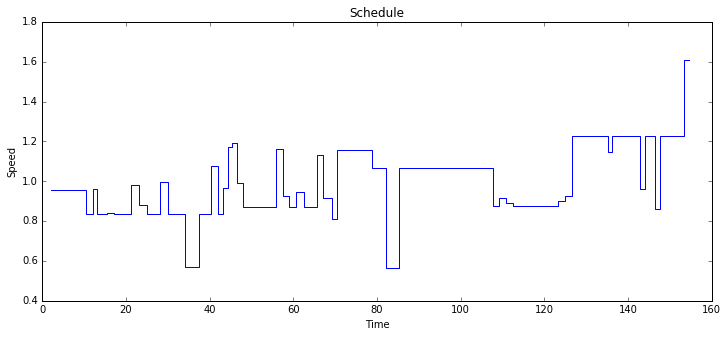

In [21]:
vehicle.schedule_plot()

## Problem 3.

Just to check my analytical solution.

In [22]:
# Initial problem

y = cvx.Variable(2)
F_1 = np.array([[0,5,0],[5,0,0],[0,0,4]])
F_2 = np.array([[0,0,0],[0,3,0],[0,0,0]])
G = np.array([[0,0,0],[0,0,0],[0,0,2]])

constraints = [
    F_1*y[0] + F_2*y[1] + G >= 0
]

objective = cvx.Minimize(2*y[1])

problem = cvx.Problem(objective, constraints)
problem.solve()
value = problem.value
print(np.round(value, 8))

0.0


In [23]:
# Dual problem

Z = cvx.Variable(3,3)
F_1 = np.array([[0,5,0],[5,0,0],[0,0,4]])
F_2 = np.array([[0,0,0],[0,3,0],[0,0,0]])
G = np.array([[0,0,0],[0,0,0],[0,0,2]])

constraints = [
    cvx.trace(Z.T@F_1) == 2,
    cvx.trace(Z.T@F_2) == 0,
    Z >= 0
]

objective = cvx.Minimize(cvx.trace(-Z.T@G))

problem = cvx.Problem(objective, constraints)
problem.solve()
value = problem.value
print(np.round(value, 8))

-1.0


## Problem 7.

$$
\textrm{minimize}_{x_1,x_2\in\mathbb{R}} 2x_1^2 + 2x_2^2 - x_1x_2\\
\textrm{subject to}\\
2x_1 + 3x_2 \geq 1,\\
5x_1 + 4x_2 \geq 1.
$$

###### QP:
$$
\textrm{minimize}_{x\in\mathbb{R}^2} \frac{1}{2}x^TPx\\
\textrm{subject to}\\
Gx \leq h\\
$$
where $P = \begin{bmatrix}4 & -1\\-1&4 \end{bmatrix}, G = \begin{bmatrix}-2 & -3\\-5&-4 \end{bmatrix}, h = \begin{bmatrix}-1\\-1\end{bmatrix}$

##### Dual:
$$
\textrm{maximize }_{\lambda \in \mathbb{R}^2}-\frac{1}{2}\lambda^TGP^{-1}G^T\lambda - \lambda^Th\\
\textrm{subject to}\\
\lambda \geq 0
$$

In [24]:
# Initial problem

x = cvx.Variable(2)
P = np.array([[4,-1],[-1,4]])
G = np.array([[-2,-3],[-5,-4]])
h = np.array([[-1],[-1]])

constraints = [
    G@x <= h
]

objective = cvx.Minimize(1/2*cvx.quad_form(x, P))

problem = cvx.Problem(objective, constraints)
problem.solve()
value = problem.value
print("p* =",value)
print("x* =", x.value)

p* = 0.1171874999741835
x* = [[ 0.17187506]
 [ 0.21874996]]


In [25]:
# Dual problem

l = cvx.Variable(2)
P = np.array([[4,-1],[-1,4]])
G = np.array([[-2,-3],[-5,-4]])
h = np.array([[-1],[-1]])


constraints = [
    l >= 0
]

objective = cvx.Maximize(-1/2*cvx.quad_form(l, G@np.linalg.inv(P)@G.T) - l.T@(h))

problem = cvx.Problem(objective, constraints)
problem.solve()
value = problem.value
print("d* =",value)
print("l* =", l.value)

d* = 0.11718750195663398
l* = [[  2.34375101e-01]
 [  1.16799917e-09]]


You see that $p^* = d^*$.

$$
\textrm{minimize}_{x_1,x_2\in\mathbb{R}} f_0(x) = 2x_1^2 + 2x_2^2 - x_1x_2\\
\textrm{subject to}\\
f_1(x) = -2x_1 - 3x_2 + 1 \leq 0,\\
f_2(x) = -5x_1 - 4x_2 + 1 \leq 0.
$$

$\Delta f_0(x) = (4x_1 - x_2, 4x_2 - x_1)\\\Delta f_1(x) = (-2, -3)\\\Delta f_0(x) = (-5, -4)$

Let us check KKT conditions:

1. $f_1(x^*) = 0 \leq 0\\f_2(x^*) = -0.73437515 \leq 0$
2. $\lambda_1 = 0.2343751 \geq 0\\ \lambda_2 = 0 \geq 0$
3. $\Delta f_0(x^*) + \lambda_1^*\Delta f_1(x^*)+ \lambda_2^*\Delta f_2(x^*) = 
(0.4687503,0.70312476) + 0.2343751\cdot(-2,-3) + (0,0) = (0,0)$
4. $\lambda_1^*f_1(x^*) = 0.2343751\cdot0 = 0,\\\lambda_2^*f_2(x^*) = 0\cdot(-0.73437515) = 0$

KKT are satisfied.